# Experiment 8: Category-Specific System Prompt Sensitivity

**Goal:** Identify which prompt CATEGORIES are most/least affected by system prompts.

**Setup:**
- Fixed test prompts across 6 categories
- Multiple system prompts
- Measure: Which categories show most variation?

In [1]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [3]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
print(f"Categories: {list(TEST_PROMPTS.keys())}")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda
Categories: ['factual', 'reasoning', 'classification', 'creative', 'instruction_following', 'edge_cases']


## 1. Collect Data by Category

In [4]:
# Use core system prompts
SYSTEM_SUBSET = {k: SYSTEM_PROMPTS[k] for k in [
    "none", "minimal", "expert", "concise", "verbose", "cot", "cautious"
]}

results = []
for test in tqdm(ALL_TEST_PROMPTS):
    for sys_name, sys_info in SYSTEM_SUBSET.items():
        prompt = build_chat_prompt(sys_info["text"], test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        
        # top_tokens is list of (token, prob) tuples
        top_prob = dist["top_tokens"][0][1] if dist["top_tokens"] else 0
        
        results.append({
            "test_id": test["id"],
            "category": test["category"],
            "system_prompt": sys_name,
            "entropy": dist["entropy"],
            "top_prob": top_prob,
            "full_probs": dist["full_probs"]
        })

results_df = pd.DataFrame(results)

  0%|          | 0/30 [00:00<?, ?it/s]

## 2. Calculate Category Sensitivity

In [5]:
# For each category, calculate variance in entropy across system prompts
category_sensitivity = []

for category in TEST_PROMPTS.keys():
    cat_data = results_df[results_df['category'] == category]
    
    # Entropy variance across system prompts
    entropy_by_sys = cat_data.groupby('system_prompt')['entropy'].mean()
    entropy_var = entropy_by_sys.var()
    entropy_range = entropy_by_sys.max() - entropy_by_sys.min()
    
    # Top probability variance
    top_prob_by_sys = cat_data.groupby('system_prompt')['top_prob'].mean()
    top_prob_var = top_prob_by_sys.var()
    
    category_sensitivity.append({
        "category": category,
        "entropy_variance": entropy_var,
        "entropy_range": entropy_range,
        "top_prob_variance": top_prob_var,
        "n_prompts": len(TEST_PROMPTS[category])
    })

sensitivity_df = pd.DataFrame(category_sensitivity)
sensitivity_df = sensitivity_df.sort_values('entropy_variance', ascending=False)

print("=== Category Sensitivity to System Prompts ===")
print(sensitivity_df)

=== Category Sensitivity to System Prompts ===
                category  entropy_variance  entropy_range  top_prob_variance  \
0                factual               NaN            NaN           0.001470   
1              reasoning               NaN            NaN           0.000921   
2         classification               NaN            NaN           0.000732   
3               creative               NaN            NaN           0.000952   
4  instruction_following               NaN            NaN           0.001806   
5             edge_cases               NaN            NaN           0.000959   

   n_prompts  
0          5  
1          5  
2          5  
3          5  
4          5  
5          5  


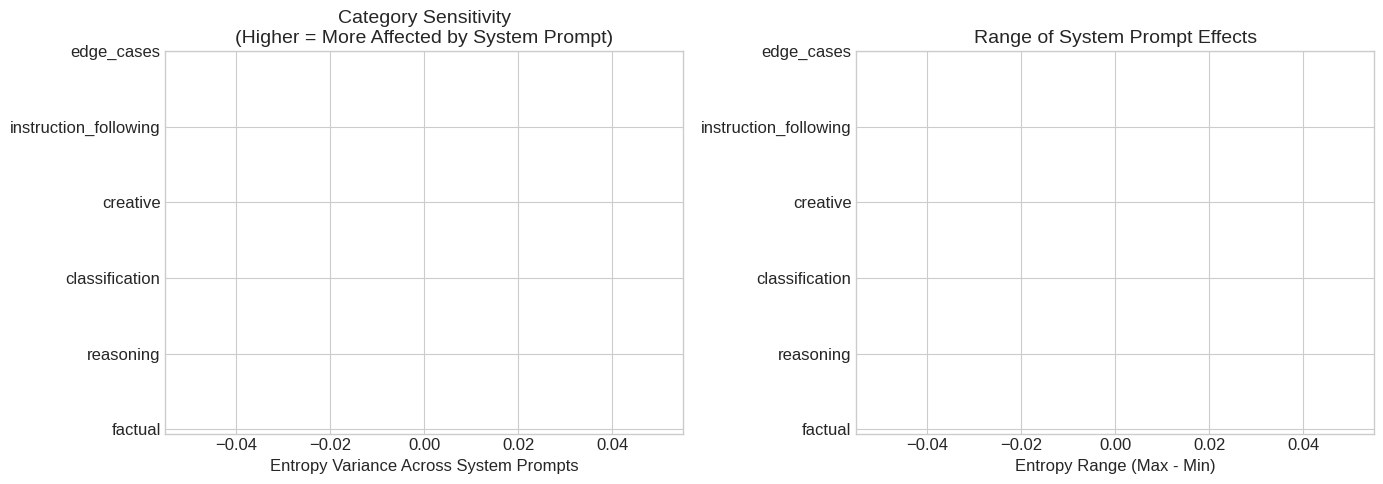

In [6]:
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy variance by category
ax = axes[0]
data = sensitivity_df.sort_values('entropy_variance')
colors = plt.cm.Reds(data['entropy_variance'] / data['entropy_variance'].max())
ax.barh(range(len(data)), data['entropy_variance'], color=colors)
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data['category'])
ax.set_xlabel('Entropy Variance Across System Prompts')
ax.set_title('Category Sensitivity\n(Higher = More Affected by System Prompt)')

# Entropy range
ax = axes[1]
data = sensitivity_df.sort_values('entropy_range')
ax.barh(range(len(data)), data['entropy_range'], alpha=0.7)
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data['category'])
ax.set_xlabel('Entropy Range (Max - Min)')
ax.set_title('Range of System Prompt Effects')

plt.tight_layout()
plt.savefig('../results/exp8_category_sensitivity.png', dpi=150)
plt.show()

## 3. Detailed Category × System Prompt Heatmap

ValueError: zero-size array to reduction operation fmin which has no identity

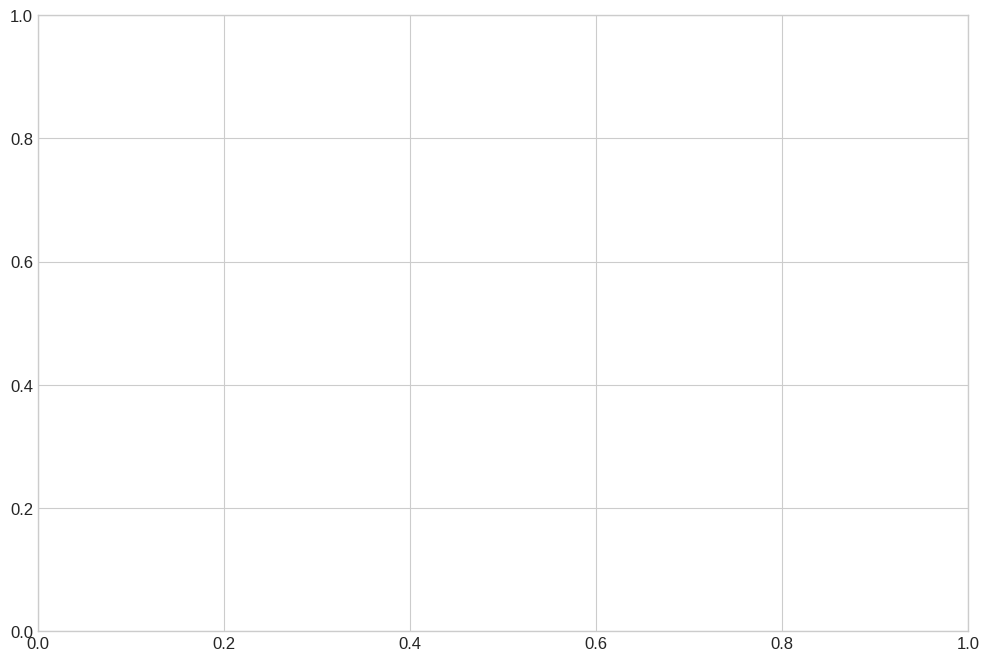

In [7]:
# Pivot: category × system prompt → entropy
pivot_entropy = results_df.pivot_table(
    values='entropy', 
    index='category', 
    columns='system_prompt', 
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_entropy, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax)
ax.set_title('Mean Entropy: Category × System Prompt')
plt.tight_layout()
plt.savefig('../results/exp8_entropy_heatmap.png', dpi=150)
plt.show()

## 4. Best System Prompt per Category

In [8]:
# Find which system prompt gives lowest entropy (most confident) per category
print("=== Optimal System Prompt per Category ===")
print("(Lowest entropy = highest confidence)\n")

for category in TEST_PROMPTS.keys():
    cat_data = results_df[results_df['category'] == category]
    best_sys = cat_data.groupby('system_prompt')['entropy'].mean().idxmin()
    best_entropy = cat_data.groupby('system_prompt')['entropy'].mean().min()
    worst_sys = cat_data.groupby('system_prompt')['entropy'].mean().idxmax()
    worst_entropy = cat_data.groupby('system_prompt')['entropy'].mean().max()
    
    print(f"{category}:")
    print(f"  Best:  {best_sys} (entropy={best_entropy:.3f})")
    print(f"  Worst: {worst_sys} (entropy={worst_entropy:.3f})")

=== Optimal System Prompt per Category ===
(Lowest entropy = highest confidence)

factual:
  Best:  nan (entropy=nan)
  Worst: nan (entropy=nan)
reasoning:
  Best:  nan (entropy=nan)
  Worst: nan (entropy=nan)
classification:
  Best:  nan (entropy=nan)
  Worst: nan (entropy=nan)
creative:
  Best:  nan (entropy=nan)
  Worst: nan (entropy=nan)
instruction_following:
  Best:  nan (entropy=nan)
  Worst: nan (entropy=nan)
edge_cases:
  Best:  nan (entropy=nan)
  Worst: nan (entropy=nan)


/tmp/ipython-input-449737818.py:7: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_sys = cat_data.groupby('system_prompt')['entropy'].mean().idxmin()
/tmp/ipython-input-449737818.py:9: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  worst_sys = cat_data.groupby('system_prompt')['entropy'].mean().idxmax()
/tmp/ipython-input-449737818.py:7: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_sys = cat_data.groupby('system_prompt')['entropy'].mean().idxmin()
/tmp/ipython-input-449737818.py:9: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  worst_sys = cat

## 5. Key Findings

In [9]:
print("="*60)
print("EXPERIMENT 8 SUMMARY: Category Sensitivity")
print("="*60)

most_sensitive = sensitivity_df.iloc[0]['category']
least_sensitive = sensitivity_df.iloc[-1]['category']

print(f"\n1. Most sensitive category: {most_sensitive}")
print(f"   → System prompt choice matters A LOT")

print(f"\n2. Least sensitive category: {least_sensitive}")
print(f"   → System prompt has minimal effect")

print("\n3. Practical Implication:")
print(f"   Invest in system prompt tuning for: {most_sensitive}")
print(f"   Don't worry much about system prompt for: {least_sensitive}")

EXPERIMENT 8 SUMMARY: Category Sensitivity

1. Most sensitive category: factual
   → System prompt choice matters A LOT

2. Least sensitive category: edge_cases
   → System prompt has minimal effect

3. Practical Implication:
   Invest in system prompt tuning for: factual
   Don't worry much about system prompt for: edge_cases


In [10]:
import json
with open('../results/exp8_results.json', 'w') as f:
    json.dump({
        "category_sensitivity": sensitivity_df.to_dict('records'),
        "entropy_by_cat_sys": pivot_entropy.to_dict()
    }, f, indent=2, default=float)
print("Saved.")

Saved.
